In [1]:
# Import libraries

import numpy as np
import sqlite3
import pandas as pd
import geopandas as gpd
import json
from shapely import wkt
from shapely import MultiPoint
from shapely.geometry import Polygon, Point
import calendar
import matplotlib.pyplot as plt

db_location = 'C:/Users/Andras/Documents/GitHub/DataSystemsProjectG5/Code/data/AMS_data.sqlite'
import streamlit as st

In [2]:
# Import CBS grid data for AMSTERDAM

# Load data from SQLite database
with sqlite3.connect(db_location) as conn:
    ams_grid = pd.read_sql('SELECT geometry FROM "CBS Amsterdam"', conn)
    ams_boundaries = pd.read_sql('SELECT "geometrie.type","geometrie.coordinates" FROM "residential areas"', conn)
    
ams_grid['geometry'] = ams_grid['geometry'].apply(wkt.loads)
ams_grid = gpd.GeoDataFrame(ams_grid, crs='epsg:28992')

ams_boundaries['geometry'] = ams_boundaries['geometrie.coordinates'].apply(lambda x: Polygon(json.loads(x)[0]))
ams_boundaries = gpd.GeoDataFrame(ams_boundaries['geometry'], crs='epsg:28992')
amsterdam_resid = ams_boundaries.dissolve().values[0][0]

In [3]:
# Create new grid covering entire region

# Grid dimensions
grid_resolution_x = 100  # metres
grid_resolution_y = 100  # metres

# Create grid in geometry format
xmin, ymin, xmax, ymax = ams_grid.total_bounds

expanded_grid_blocks = []
x_boundaries = np.arange(xmin, xmax, grid_resolution_x)
y_boundaries = np.arange(ymin, ymax, grid_resolution_y)

for i, x in enumerate(x_boundaries):
    for j, y in enumerate(y_boundaries):

        block = Polygon([
            (x,y), 
            (x+grid_resolution_x, y),
            (x+grid_resolution_x, y+grid_resolution_y),
            (x, y+grid_resolution_y)])
        expanded_grid_blocks.append(block)
        
new_grid = gpd.GeoDataFrame({'geometry':expanded_grid_blocks}, crs='epsg:28992')
new_ams = new_grid[new_grid.within(amsterdam_resid)].copy()

In [4]:
# Calculate building density on grid
# Load data
with sqlite3.connect(db_location) as conn:
    trees = pd.read_sql('SELECT boomhoogteklasseActueel,jaarVanAanleg,soortnaamKort,"geometrie.coordinates" FROM "trees"', conn)
    buildings = pd.read_sql('SELECT oorspronkelijkBouwjaar,statusOmschrijving,"geometrie.coordinates" FROM "buildings"', conn)

buildings['geometrie.coordinates'] = buildings['geometrie.coordinates'].apply(lambda x: json.loads(x))
buildings = buildings.dropna(subset=['geometrie.coordinates'])
buildings['geometry'] = buildings['geometrie.coordinates'].apply(lambda x: Polygon(x[0]))
buildings = gpd.GeoDataFrame(buildings.drop(columns=['geometrie.coordinates']), crs='epsg:28992')

# Fix building year issue
buildings['oorspronkelijkBouwjaar'] = buildings['oorspronkelijkBouwjaar'].replace({1005:1900})

In [6]:
# Calculate tree density on grid

trees['geometrie.coordinates'] = trees['geometrie.coordinates'].apply(lambda x: json.loads(x))
trees = trees.dropna(subset=['geometrie.coordinates'])
trees['geometry'] = trees['geometrie.coordinates'].apply(lambda xy: Point(xy))
trees = gpd.GeoDataFrame(trees.drop(columns=['geometrie.coordinates']), crs='epsg:28992')

height_class = {
    'ZZ_Vervallen 12 tot 18 m.' : np.nan, 
    'ZZ_Vervallen 6 tot 12 m.' : np.nan,
    'ZZ_Vervallen Onbekend' : np.nan, 
    'a. tot 6 m.' : 0.5, 
    'b. 6 tot 9 m.' : 1,
    'c. 9 tot 12 m.' : 1.5, 
    'd. 12 tot 15 m.' : 2, 
    'e. 15 tot 18 m.' : 2.5,
    'f. 18 tot 24 m.' : 3, 
    'g. 24 m. en hoger' : 3.5, 
    'q. Niet van toepassing' : np.nan,
    None : np.nan}

trees['height_class'] = trees['boomhoogteklasseActueel'].replace(height_class)
trees = trees.dropna(subset=['height_class'])

new_ams['trees'] =  new_ams['geometry'].apply(lambda x: trees[trees.within(x)]['height_class'].sum())

C:\Users\Andras\AppData\Local\Temp\ipykernel_18472\1327098485.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees['geometry'] = trees['geometrie.coordinates'].apply(lambda xy: Point(xy))


In [7]:
from shapely import unary_union

grid_cells = new_ams['geometry'].reset_index(drop=True)
building_cells = buildings[buildings['statusOmschrijving']=='Pand in gebruik'][['geometry','oorspronkelijkBouwjaar']].reset_index(drop=True)
building_cells['age'] = 2023 - building_cells['oorspronkelijkBouwjaar']

grids_with_polygons = gpd.sjoin(left_df=grid_cells.to_frame(), right_df=building_cells, how='inner')

building_area_per_block = np.zeros(len(grid_cells))
average_age_per_block = np.zeros(len(grid_cells))

for pos in grids_with_polygons.index.unique():
    
    buildings_in_pos = building_cells.loc[ grids_with_polygons.loc[[pos], 'index_right']]
    join_buildings = unary_union(buildings_in_pos['geometry'])
    area = join_buildings.intersection(grid_cells.loc[pos]).area
    building_area_per_block[pos] = area
    
    buildings_in_pos['area'] = buildings_in_pos['geometry'].map(lambda x: x.intersection(grid_cells.loc[pos]).area )
    average_age_per_block[pos] = np.average(buildings_in_pos['age'], weights=buildings_in_pos['area'])

new_ams['building_area'] = building_area_per_block / (grid_resolution_x*grid_resolution_y)
new_ams['average_building_age'] = average_age_per_block

reduced_amsgrid = new_ams[ (new_ams['building_area']>0) | (new_ams['trees']>0) ]

In [8]:
reduced_amsgrid.explore('average_building_age')

In [9]:
new_ams.head()

geometry  trees  building_area  \
130  POLYGON ((111400.000 490300.000, 111500.000 49...    0.0       0.000000   
131  POLYGON ((111400.000 490400.000, 111500.000 49...    0.0       0.001720   
132  POLYGON ((111400.000 490500.000, 111500.000 49...    0.0       0.033969   
133  POLYGON ((111400.000 490600.000, 111500.000 49...    0.0       0.000000   
134  POLYGON ((111400.000 490700.000, 111500.000 49...    0.0       0.000000   

     average_building_age  
130                   0.0  
131                  25.0  
132                  25.0  
133                   0.0  
134                   0.0

In [188]:
def count_high_winds(series):
    return (series > 15).sum()
def sum_precipitation(series):
    return series.sum()
def avg_wind(series):
    return series.mean()
def leaves_on(x):
    if x in ['October','November', 'December','January', 'February', 'March']:
        return 0
    else:
        return 1

In [235]:
# Combine incidents with weather data
from pandas.api.types import CategoricalDtype
cat_type_dir = CategoricalDtype(categories=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], ordered=False)
cat_type_hour = CategoricalDtype(categories=range(24), ordered=False)
cat_type_month = CategoricalDtype(categories=[calendar.month_name[i+1] for i in range(12)], ordered=False)

# Load weather and incident data
with sqlite3.connect(db_location) as conn:
    weather = pd.read_sql('SELECT * FROM "WeatherDataH"', conn)
    incidents = pd.read_sql('SELECT * FROM "Incidents"', conn)

weather['Wind direction (degrees)'] = weather['Wind direction (degrees)'].replace({360:0,990:200})
weather['Wind direction (direction)'] = pd.cut(weather['Wind direction (degrees)'], 
                                        bins=np.append(np.insert(np.arange(0,360,45)+22.5,0,0),360),
                                        ordered=False, 
                                        labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']).astype(cat_type_dir)           

month_dict = dict(zip(range(1,13), calendar.month_name[1:]))
weather['month'] = pd.to_datetime(weather['Date'], format='%Y%m%d').dt.month.replace(month_dict).astype(cat_type_month)
weather['Hour'] = weather['Hour'].replace({24:0}).astype(cat_type_hour)
weather['Hourly precipitation amount (mm)'] = weather['Hourly precipitation amount (mm)'].replace({-0.01 : 0.00})
weather['Precipitation past week'] = weather['Hourly precipitation amount (mm)'].rolling(window=172).apply(sum_precipitation)
weather['Strong wind past two days'] = weather['Average hourly wind speed (m/s)'].rolling(window=48).apply(count_high_winds)
weather['Average wind past two days'] = weather['Average hourly wind speed (m/s)'].rolling(window=48).apply(avg_wind)
weather['Max wind past day'] = weather['Maximum hourly wind speed (m/s)'].rolling(window=24).apply(max)
weather['Leaves on or not'] = weather['month'].apply(leaves_on)
weather['Snowy hours past day'] = weather['Snow'].rolling(window=24).apply(sum_precipitation)

incidents['geometry'] = gpd.points_from_xy(incidents['LON'], incidents['LAT'])
incidents = gpd.GeoDataFrame(incidents, crs='epsg:4326', geometry='geometry')
incidents = incidents.to_crs('epsg:28992')
    
incidents['date_int'] = pd.to_datetime(incidents['Date']).dt.strftime("%Y%m%d").astype('int64')
incidents['hour_int'] = pd.to_datetime(incidents['Incident_Starttime'], format="%H:%M:%S.%f").dt.hour.astype(cat_type_hour)
incidents['month'] = pd.to_datetime(incidents['Date']).dt.month.replace(month_dict).astype(cat_type_month)

incidents_weather = incidents.merge(weather, how='left', left_on=['date_int', 'hour_int', 'month'], right_on=['Date','Hour','month'])

all_data = gpd.sjoin(left_df=incidents_weather, right_df=reduced_amsgrid, how='left').dropna(subset=['building_area', 'trees'])

In [122]:
all_data[all_data['Damage_Type']=='Tree'].size

92700

In [203]:
all_data['Damage_Type'].unique()

array(['Tree', 'Building', 'Fence, Road signs, Scaffolding', 'Unknown'],
      dtype=object)

In [278]:
import random

# Create training set

weather_columns = [
#    'month', 
#    'Wind direction (direction)', 
#    'Snowy hours past day',
    'Leaves on or not',
    'Average hourly wind speed (m/s)', 
    'Maximum hourly wind speed (m/s)',
    'Precipitation past week',
    'Strong wind past two days',
    'Average wind past two days',
    'Max wind past day']

grid_columns = [
    'building_area',
    'average_building_age',
    'trees']

positive_examples_tree = all_data[all_data['Damage_Type'].isin(['Tree','Fence, Road signs, Scaffolding', 'Unknown'])][weather_columns+grid_columns].dropna().copy()
positive_examples_tree['event'] = 1

positive_examples_building = all_data[all_data['Damage_Type'].isin(['Building','Fence, Road signs, Scaffolding', 'Unknown'])][weather_columns+grid_columns].dropna().copy()
positive_examples_building['event'] = 1

number_negatives = 6000

random_weather = weather.sample(number_negatives, replace=True)
random_grids = reduced_amsgrid.sample(number_negatives, replace=True)

negative_examples = pd.concat([random_weather[weather_columns].reset_index(drop=True), random_grids[grid_columns].reset_index(drop=True)], axis=1)
negative_examples['event'] = 0

train_data_tree = pd.concat([positive_examples_tree, negative_examples])
train_data_building = pd.concat([positive_examples_building, negative_examples])

duplicates_tree = train_data_tree.duplicated(subset=train_data_tree.columns.difference(['event']), keep='first')
train_data_tree = train_data_tree[~((train_data_tree['event']==0) & (duplicates_tree))]

duplicates_building = train_data_building.duplicated(subset=train_data_building.columns.difference(['event']), keep='first')
train_data_building = train_data_building[~((train_data_building['event']==0) & (duplicates_building))]

#for column in ['month']:
#
#    train_data_tree = pd.concat([train_data_tree, pd.get_dummies(train_data_tree[column])], axis=1)
#    train_data_tree = train_data_tree.drop(columns=[column])
#    train_data_building = pd.concat([train_data_building, pd.get_dummies(train_data_building[column])], axis=1)
#    train_data_building = train_data_building.drop(columns=[column])

train_data_tree.columns = train_data_tree.columns.astype(str)
train_data_tree[train_data_tree['average_building_age']>300]['average_building_age'] = 300
train_data_tree[train_data_tree['trees']>200]['trees'] = 200

train_data_building.columns = train_data_building.columns.astype(str)
train_data_building[train_data_building['average_building_age']>300]['average_building_age'] = 300
train_data_building[train_data_building['trees']>200]['trees'] = 200


Y_tree=train_data_tree['event']
X_tree = train_data_tree.drop(columns=['event', 'building_area', 'average_building_age'])
Y_building=train_data_building['event']
X_building = train_data_building.drop(columns=['event', 'trees'])


C:\Users\Andras\AppData\Local\Temp\ipykernel_18472\2077847354.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_tree[train_data_tree['average_building_age']>300]['average_building_age'] = 300
C:\Users\Andras\AppData\Local\Temp\ipykernel_18472\2077847354.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_tree[train_data_tree['trees']>200]['trees'] = 200
C:\Users\Andras\AppData\Local\Temp\ipykernel_18472\2077847354.py:57: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [279]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

In [280]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_tree, Y_tree, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_building, Y_building, test_size=0.2, random_state=42)

In [283]:
from xgboost import XGBClassifier
from scipy.sparse import lil_matrix
from sklearn.preprocessing import StandardScaler

#scaler_event = StandardScaler()

#clf_event = XGBClassifier(objective='binary:logistic')

#clf_event.fit(X_train, y_train)
#clf_event.fit(scaler_event.fit_transform(X_train), y_train)

building_pipeline = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier(objective='binary:logistic'))])
tree_pipeline = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier(objective='binary:logistic'))])

tree_pipeline.fit(X_train_t, y_train_t)
building_pipeline.fit(X_train_b, y_train_b)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [284]:
tree_probs = tree_pipeline.predict_proba(X_test_t)[:,1]
building_probs = building_pipeline.predict_proba(X_test_b)[:,1]

# Set a lower threshold
threshold = 0.3
preds_tree = (tree_probs > threshold).astype(int)
preds_building = (building_probs > threshold).astype(int)

Trees:
Accuracy: 0.8448
Precision: 0.7569
Recall: 0.8185
F1 Score: 0.7865
ROC AUC: 0.8387

Buildings:
Accuracy: 0.8944
Precision: 0.8069
Recall: 0.8763
F1 Score: 0.8402
ROC AUC: 0.8895

Confusion Matrices:
[[1023  168]
 [ 116  523]]
[[1086  117]
 [  69  489]]


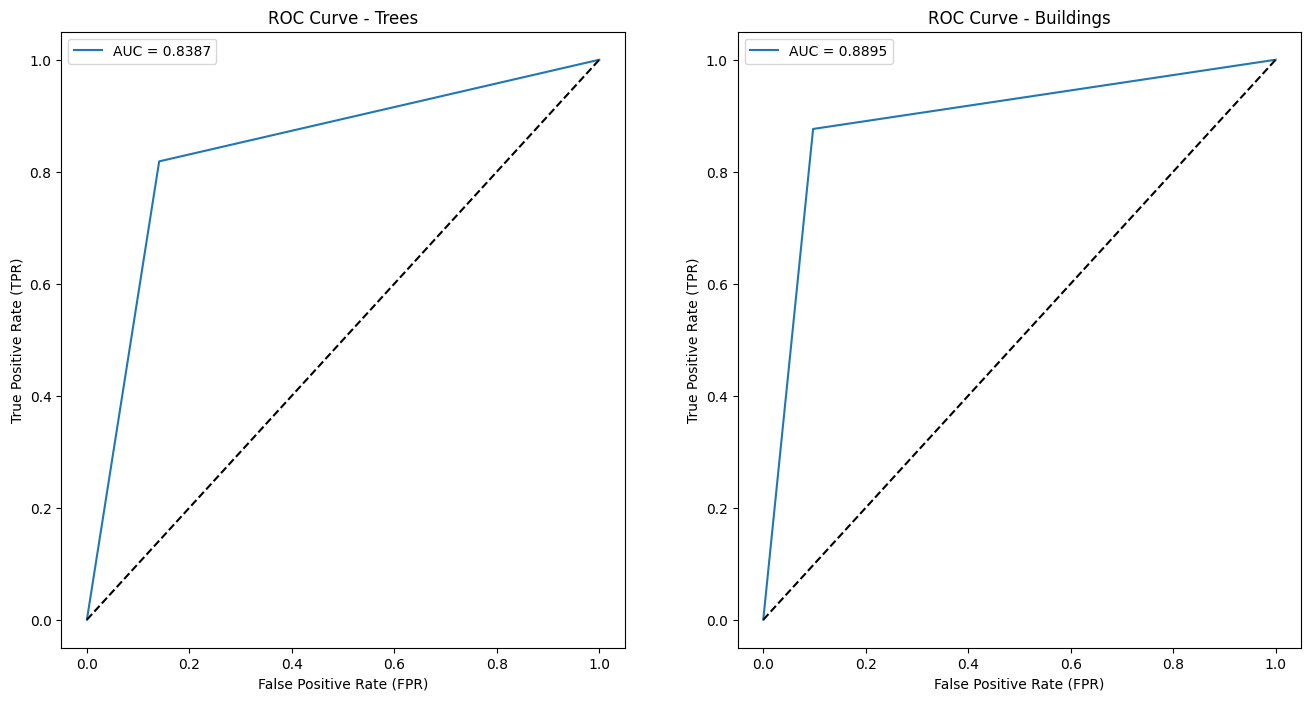

In [289]:
# Binary classification evaluation metrics
accuracy_t = accuracy_score(y_test_t, preds_tree)
precision_t = precision_score(y_test_t, preds_tree)
recall_t = recall_score(y_test_t, preds_tree)
f1_t = f1_score(y_test_t, preds_tree)
roc_auc_t = roc_auc_score(y_test_t, preds_tree)
accuracy_b = accuracy_score(y_test_b, preds_building)
precision_b = precision_score(y_test_b, preds_building)
recall_b = recall_score(y_test_b, preds_building)
f1_b = f1_score(y_test_b, preds_building)
roc_auc_b = roc_auc_score(y_test_b, preds_building)

print('Trees:')
print(f'Accuracy: {accuracy_t:.4f}')
print(f'Precision: {precision_t:.4f}')
print(f'Recall: {recall_t:.4f}')
print(f'F1 Score: {f1_t:.4f}')
print(f'ROC AUC: {roc_auc_t:.4f}\n')

print('Buildings:')
print(f'Accuracy: {accuracy_b:.4f}')
print(f'Precision: {precision_b:.4f}')
print(f'Recall: {recall_b:.4f}')
print(f'F1 Score: {f1_b:.4f}')
print(f'ROC AUC: {roc_auc_b:.4f}\n')

# Confusion Matrix
conf_matrix_t = confusion_matrix(y_test_t, preds_tree)
conf_matrix_b = confusion_matrix(y_test_b, preds_building)
print('Confusion Matrices:')
print(conf_matrix_t)
print(conf_matrix_b)

# ROC Curve
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, preds_tree)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, preds_building)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(fpr_t, tpr_t, label=f'AUC = {roc_auc_t:.4f}')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate (FPR)')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('ROC Curve - Trees')
axes[0].legend()

axes[1].plot(fpr_b, tpr_b, label=f'AUC = {roc_auc_b:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_title('ROC Curve - Buildings')
axes[1].legend()

plt.show()


In [293]:
import pickle

with open('xgb_building_pipeline.pickle', 'wb') as handle:
    pickle.dump(building_pipeline, handle)
    
with open('xgb_tree_pipeline.pickle', 'wb') as handle:
    pickle.dump(tree_pipeline, handle)

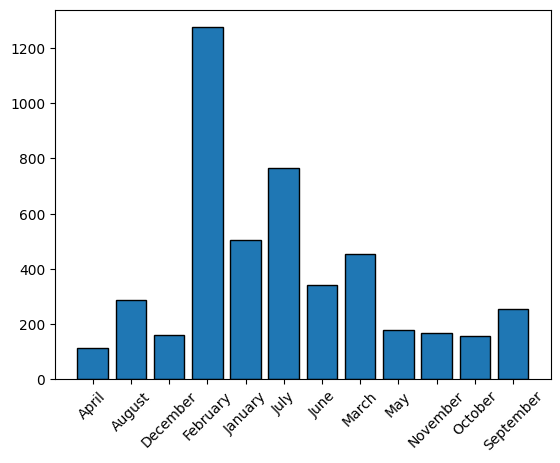

In [53]:
unique_months, counts = zip(*sorted(all_data['month'].value_counts().items()))
plt.bar(unique_months, counts, edgecolor='black')

plt.xticks(range(len(unique_months)), unique_months, rotation=45, ha='center')

# Display the plot
plt.show()

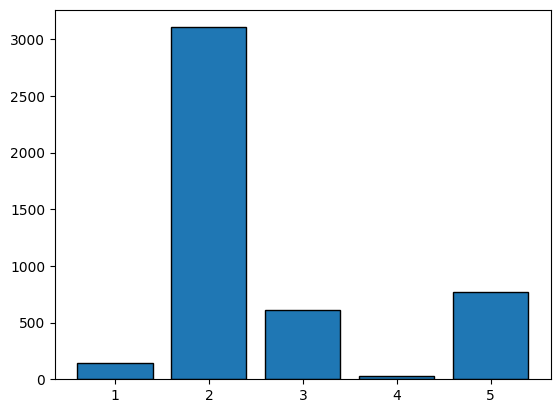

In [60]:
unique_prios, counts = zip(*sorted(all_data['Incident_Priority'].value_counts().items()))
plt.bar(unique_prios, counts, edgecolor='black')

plt.xticks(ha='center')

# Display the plot
plt.show()

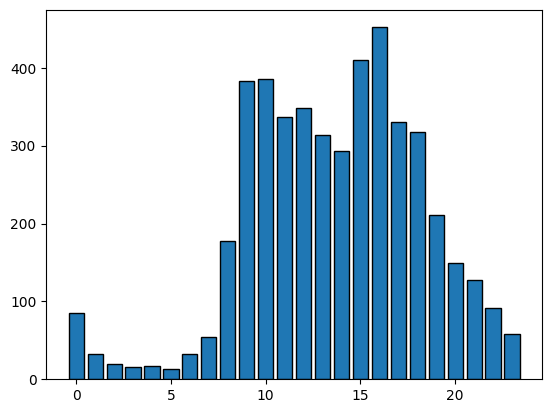

In [292]:
unique_hrs, counts = zip(*sorted(all_data['Hour'].value_counts().items()))
plt.bar(unique_hrs, counts, edgecolor='black')

plt.xticks(ha='center')

# Display the plot
plt.show()

In [290]:
all_data.columns

Index(['Incident_ID', 'Date_x', 'Incident_Starttime', 'Incident_Endtime',
       'Incident_Duration', 'Incident_Priority', 'Service_Area',
       'Municipality', 'Damage_Type', 'LON', 'LAT', 'geometry', 'date_int',
       'hour_int', 'month', 'index', 'Station Number', 'Date_y', 'Hour',
       'Wind direction (degrees)', 'Average hourly wind speed (m/s)',
       'Average wind speed 10mins (m/s)', 'Maximum hourly wind speed (m/s)',
       'Temperature (C)', 'Minimum temperature 6hours (C)',
       'Dew point temperature (C)', 'Sunshine duration (uur)',
       'Global radiation (J/cm2)', 'Precipitation duration (uur)',
       'Hourly precipitation amount (mm)', 'Air pressure (hPa)',
       'Horizontal visibility', 'Cloud cover (in octants)',
       'Relative atmospheric humidity (percent)',
       'Present weather code (00-99)', 'Indicator present weather code', 'Fog',
       'Rainfall', 'Snow', 'Thunder', 'Ice formation',
       'Wind direction (direction)', 'Precipitation past week',
 

In [37]:
weather.tail()

index  Station Number      Date Hour  Wind direction (degrees)  \
165211  165211             240  20231106   20                       210   
165212  165212             240  20231106   21                       210   
165213  165213             240  20231106   22                       190   
165214  165214             240  20231106   23                       200   
165215  165215             240  20231106    0                       200   

        Average hourly wind speed (m/s)  Average wind speed 10mins (m/s)  \
165211                                8                                7   
165212                                7                                7   
165213                                7                                6   
165214                                5                                5   
165215                                6                                6   

        Maximum hourly wind speed (m/s)  Temperature (C)  \
165211                               11              9.6   
165212                               10              9.8   
165213                               12              9.3   
165214                                8              8.8   
165215                                9              8.9   

        Minimum temperature 6hours (C)  ...  Indicator present weather code  \
165211                             NaN  ...                               7   
165212                             NaN  ...                               7   
165213                             NaN  ...                               7   
165214                             NaN  ...                               5   
165215                             7.6  ...                               7   

        Fog  Rainfall  Snow  Thunder  Ice formation  \
165211  0.0       1.0   0.0      0.0            0.0   
165212  0.0       1.0   0.0      0.0            0.0   
165213  0.0       1.0   0.0      1.0            0.0   
165214  0.0       0.0   0.0      0.0            0.0   
165215  0.0       0.0   0.0      0.0            0.0   

        Wind direction (direction)     month  Strong wind past two days  \
165211                          SW  November                        0.0   
165212                          SW  November                        0.0   
165213                           S  November                        0.0   
165214                           S  November                        0.0   
165215                           S  November                        0.0   

        Precipitation past week  
165211                     70.6  
165212                     69.8  
165213                     70.1  
165214                     68.8  
165215                     68.0  

[5 rows x 30 columns]

In [39]:
all_data.columns

Index(['Incident_ID', 'Date_x', 'Incident_Starttime', 'Incident_Endtime',
       'Incident_Duration', 'Incident_Priority', 'Service_Area',
       'Municipality', 'Damage_Type', 'LON', 'LAT', 'geometry', 'date_int',
       'hour_int', 'month', 'index', 'Station Number', 'Date_y', 'Hour',
       'Wind direction (degrees)', 'Average hourly wind speed (m/s)',
       'Average wind speed 10mins (m/s)', 'Maximum hourly wind speed (m/s)',
       'Temperature (C)', 'Minimum temperature 6hours (C)',
       'Dew point temperature (C)', 'Sunshine duration (uur)',
       'Global radiation (J/cm2)', 'Precipitation duration (uur)',
       'Hourly precipitation amount (mm)', 'Air pressure (hPa)',
       'Horizontal visibility', 'Cloud cover (in octants)',
       'Relative atmospheric humidity (percent)',
       'Present weather code (00-99)', 'Indicator present weather code', 'Fog',
       'Rainfall', 'Snow', 'Thunder', 'Ice formation',
       'Wind direction (direction)', 'index_right', 'trees', 'bui